query（自主提示）和key（非自主提示）之间的交互形成了注意力汇聚； 注意力汇聚有选择地聚合了value（感官输入）以生成最终的输出。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 生成数据集
考虑下面的回归问题，如何学习f来预测任意的新输入x的输出y_hat
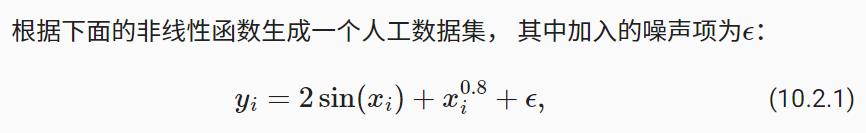

In [6]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)  # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

# 训练样本的输出
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  

x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出

n_test = len(x_test)  # 测试样本数
n_test

50

下面的函数将绘制所有的训练样本（样本由圆圈表示），以及不带噪声项的真实输出值，以及学习得到的预测值。

In [7]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    # 画出训练样本
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## 平均汇聚
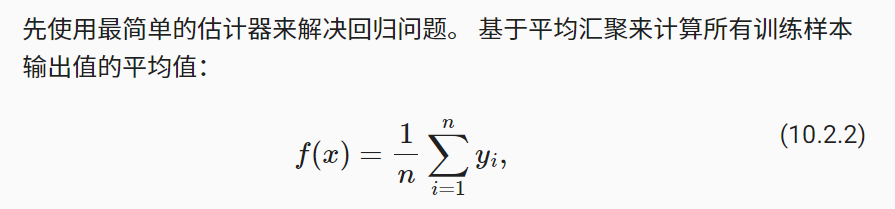

使用最简单的平均汇聚解决回归问题（没有参数学习，直接把所有样本的均值作为预测值）


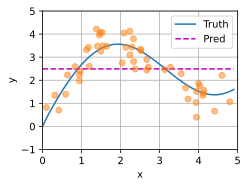

In [8]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

##  非参注意力汇聚（无需训练）
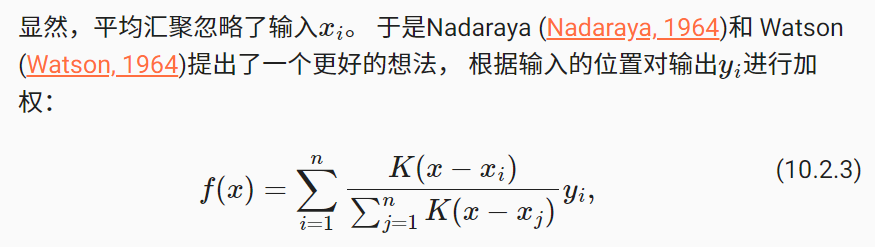
K是核，上述描述的估计器被称为Nadaraya-Watson核回归

更加通用的注意力汇聚公式：
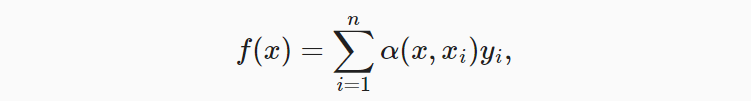

当K使用高斯核，带入f(x)
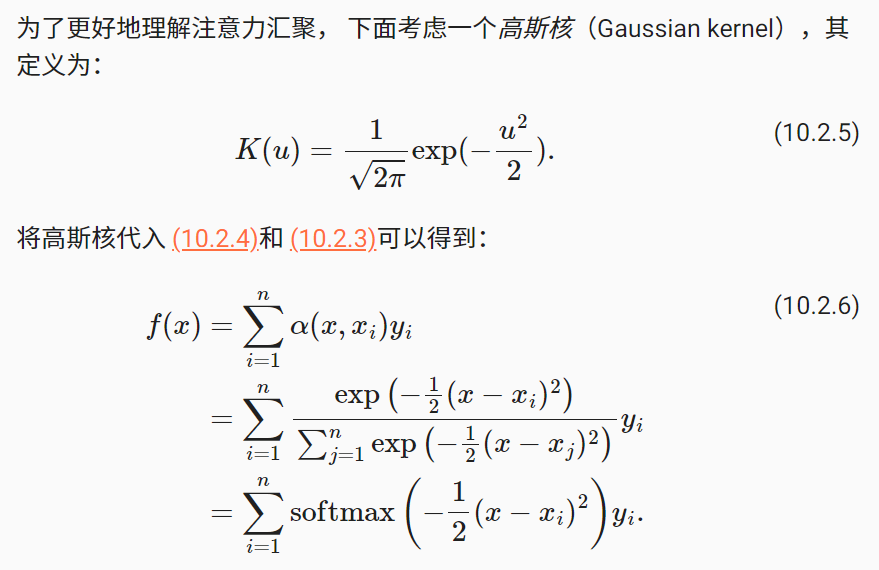

如果一个键x_i越是接近给定的查询，那么分配给这个键对应值y_i的注意力权重就越大，也就获得了更多的注意力

值得注意的是，Nadaraya-Watson核回归是一个非参数模型。接下来，我们将基于这个非参数的注意力汇聚模型来绘制预测结果。 从绘制的结果会发现新的模型预测线是平滑的，并且比之前使用平均汇聚的预测更接近真实。

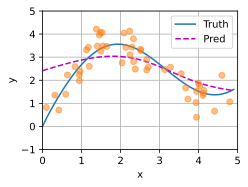

In [9]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))

# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着当前查询x对所有训练样本值（y_train）的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)

# y_hat是对所有训练样本值的加权和
y_hat = torch.matmul(attention_weights, y_train)

plot_kernel_reg(y_hat)

现在来观察注意力的权重。 这里测试数据的输入x相当于查询(query)，而训练数据的输入x_i相当于键(key)。 因为两个输入都是经过排序的，因此由观察可知“query-key”对越接近， 注意力汇聚的注意力权重就越高, 即越关心该key对应的value。

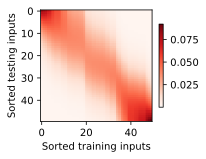

In [10]:
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs',
    ylabel='Sorted testing inputs')

<b>按理来说只要有足够多的数据，不需要参数也能预测的很好，但是往往是没有足够的数据，因此非参数注意力汇聚在ML用的不多</b>

## 带参的注意力汇聚（需要训练）
将可学习的参数集成到注意力汇聚中
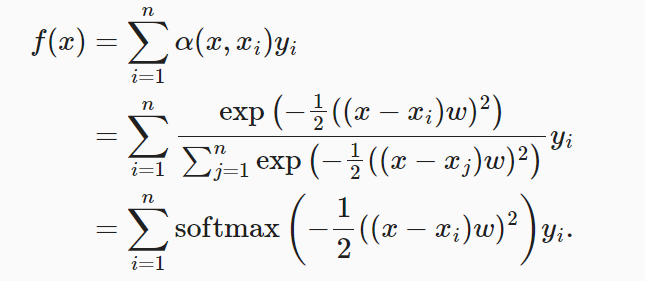

## 定义模型
定义Nadaraya-Watson核回归的带参数版本

In [11]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        """
        queries: 要预测的所有输入
        (keys, values):由所有训练样本转换出来的键值对
        
        """
        # queries和attention_weights的形状为(查询个数，“键－值”对个数即训练样本数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

## 训练
将训练数据集变换为键和值用于训练注意力模型。

 在带参数的注意力汇聚模型中， 任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算， 从而得到其对应的预测输出。

In [12]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

训练带参数的注意力汇聚模型时，使用平方损失函数和随机梯度下降。

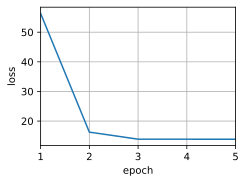

In [13]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

如下所示，训练完带参数的注意力汇聚模型后可以发现： 在尝试拟合带噪声的训练数据时， 预测结果绘制的线不如之前非参数模型的平滑。

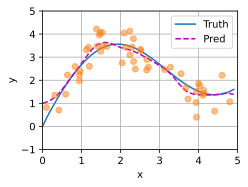

In [14]:
# keys的形状:(n_test，n_train)
# 每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))

# values的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))

y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

为什么新的模型更不平滑了呢？ 下面看一下输出结果的绘制图： 与非参数的注意力汇聚模型相比， 带参数的模型加入可学习的参数后， 曲线在注意力权重较大的区域变得更不平滑。

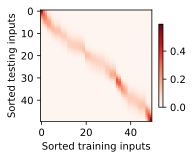

In [15]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 小结
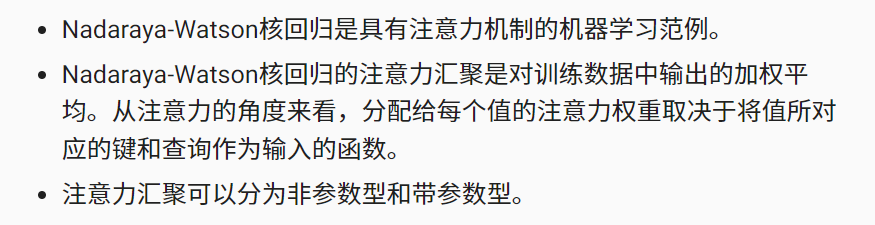